https://realpython.com/build-llm-rag-chatbot-with-langchain/

In [1]:
!pip install py2neo -q
!pip install neo4j -q

In [1]:
from neo4j import GraphDatabase
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI

In [10]:
from neo4j import GraphDatabase

class GraphDBManager:
    def __init__(self, uri, user, password):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self.driver.close()

    def clear_database(self):
        with self.driver.session() as session:
            session.execute_write(self._delete_all)

    @staticmethod
    def _delete_all(tx):
        query = "MATCH (n) DETACH DELETE n"
        tx.run(query)

    def create_person(self, name):
        with self.driver.session() as session:
            session.execute_write(self._create_and_return_person, name)

    @staticmethod
    def _create_and_return_person(tx, name):
        query = "CREATE (p:Person {name: $name}) RETURN p"
        tx.run(query, name=name)

    def create_place(self, name):
        with self.driver.session() as session:
            session.execute_write(self._create_and_return_place, name)

    @staticmethod
    def _create_and_return_place(tx, name):
        query = "CREATE (p:Place {name: $name}) RETURN p"
        tx.run(query, name=name)

    def relate_people(self, name1, name2, relationship_type):
        with self.driver.session() as session:
            session.execute_write(self._create_relationship, name1, name2, relationship_type)

    @staticmethod
    def _create_relationship(tx, name1, name2, relationship_type):
        query = (
            f"MATCH (a:Person {{name: $name1}}), (b:Person {{name: $name2}}) "
            f"CREATE (a)-[:{relationship_type}]->(b)"
        )
        tx.run(query, name1=name1, name2=name2)

    def person_visits_place(self, person_name, place_name):
        with self.driver.session() as session:
            session.execute_write(self._create_visit, person_name, place_name)

    @staticmethod
    def _create_visit(tx, person_name, place_name):
        query = (
            "MATCH (p:Person {name: $person_name}), (l:Place {name: $place_name}) "
            "CREATE (p)-[:VISITED]->(l)"
        )
        tx.run(query, person_name=person_name, place_name=place_name)

# Instantiate and use GraphDBManager
db_manager = GraphDBManager("bolt://neo4j:7687", "neo4j", "password")  # Adjust credentials

# Clear existing data
db_manager.clear_database()

# Create persons and places
persons = ["Alice", "Bob", "Charlie", "David", "Eve"]
for person in persons:
    db_manager.create_person(person)
    
places = ["Café Central", "Biblioteca Municipal", "Parque da Cidade"]
for place in places:
    db_manager.create_place(place)

# Create relationships
relationships = [
    ("Alice", "Bob", "FRIENDS"),
    ("Charlie", "David", "CO_WORKERS"),
    ("Eve", "David", "CO_WORKERS"),
    ("Eve", "Alice", "FRIENDS"),
]
for rel in relationships:
    db_manager.relate_people(*rel)

# People visiting places
visits = [
    ("Alice", "Café Central"),
    ("Bob", "Biblioteca Municipal"),
    ("Charlie", "Parque da Cidade"),
    ("Eve", "Parque da Cidade"),
]
for visit in visits:
    db_manager.person_visits_place(*visit)

# Close the connection
db_manager.close()


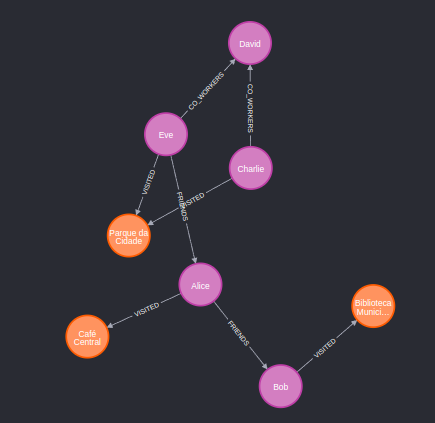

In [11]:
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI

graph = Neo4jGraph(url="bolt://neo4j:7687", username="neo4j", password="password")

In [16]:
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0, model="gpt-4"), graph=graph, verbose=True
)

In [22]:
chain.invoke({"query": "Quem visitou o Parque da Cidade?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:VISITED]->(pl:Place {name: 'Parque da Cidade'}) RETURN p.name
Full Context:
[{'p.name': 'Charlie'}, {'p.name': 'Eve'}]

> Finished chain.


{'query': 'Quem visitou o Parque da Cidade?',
 'result': 'Charlie e Eve visitaram o Parque da Cidade.'}

In [19]:
chain.invoke({"query": "Quem trabalha com Eve?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Person)-[:CO_WORKERS]->(Person {name: 'Eve'}) RETURN p.name
Full Context:
[]

> Finished chain.


{'query': 'Quem trabalha com Eve?',
 'result': 'Desculpe, eu não sei quem trabalha com Eve.'}